In [5]:
import re
import os
import fnmatch
from PIL import Image
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm.contrib.concurrent import thread_map

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

def list_files_by_type(folder_path, file_type):
    filtered_files = []
    for file in os.listdir(folder_path):
        if fnmatch.fnmatch(file, f"*.{file_type}"):
            filtered_files.append(os.path.join(folder_path, file))
    return filtered_files

def process_image(args):
    file_path, label, transform = args  # Unpack the tuple
    image = Image.open(file_path)
    default_transform = transforms.ToTensor()
    tensor = default_transform(image)
    if transform:
        tensor = transform(tensor)
    return tensor, torch.tensor(label, dtype=torch.long)

class CIFAKEDataset(Dataset):
    @staticmethod
    def extract_index_and_category(file_path):
        filename = os.path.basename(file_path)
        pattern = r"(\d+)(?: \((\d+)\))?\..+"
        match = re.match(pattern, filename)
        if match:
            index = int(match.group(1))
            category = int(match.group(2)) if match.group(2) else 0
            return index, category
        else:
            return None
    
    @staticmethod
    def load_folder(folder_path, label, category=None, transform=None, num_processes=1):
        print(f"Loading folder: {folder_path}")
        files = list_files_by_type(folder_path, "jpg")
        if category is not None:
            files = [file for file in files if CIFAKEDataset.extract_index_and_category(file)[1] == category]

        # Use process_map from tqdm.contrib.concurrent for better tqdm updates
        results = thread_map(process_image, [(file, label, transform) for file in files], max_workers=num_processes, chunksize=1)

        x = torch.stack([result[0] for result in results])
        y = torch.stack([result[1] for result in results])
        return x, y
        
    def __init__(self, folder_path, category=None, transform=None, num_processes=1):
        label_1_folders = [
            os.path.join(folder_path, "train/REAL"),
            os.path.join(folder_path, "test/REAL"),
        ]
        label_0_folders = [
            os.path.join(folder_path, "train/FAKE"),
            os.path.join(folder_path, "test/FAKE"),
        ]
        x1, y1 = CIFAKEDataset.load_folder(label_1_folders[0], 1, category, transform, num_processes)
        x2, y2 = CIFAKEDataset.load_folder(label_0_folders[0], 0, category, transform, num_processes)
        x3, y3 = CIFAKEDataset.load_folder(label_1_folders[1], 1, category, transform, num_processes)
        x4, y4 = CIFAKEDataset.load_folder(label_0_folders[1], 0, category, transform, num_processes)
        self.x = torch.cat((x1, x2, x3, x4))
        self.y = torch.cat((y1, y2, y3, y4))

    def __len__(self):
        return self.y.size(0)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def data_dim(self):
        return self.x[0].size()
    
    def show_example(self, idx):
        x, y = self[idx]
        image_array = x.permute(1, 2, 0).numpy()
        plt.imshow(image_array)
        plt.title(f"Label: {y}")
        plt.axis('off')
        plt.show()

Loading CIFAKEDataset...
Loading folder: data/CIFAKE\train/REAL


  0%|          | 0/50000 [00:00<?, ?it/s]

Loading folder: data/CIFAKE\train/FAKE


  0%|          | 0/50000 [00:00<?, ?it/s]

Loading folder: data/CIFAKE\test/REAL


  0%|          | 0/10000 [00:00<?, ?it/s]

Loading folder: data/CIFAKE\test/FAKE


  0%|          | 0/10000 [00:00<?, ?it/s]

Dataset loaded successfully!
Dataset length: 120000
Data dimension: torch.Size([3, 32, 32])
Showing example image...


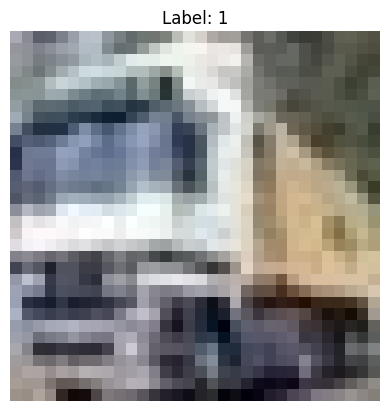

In [6]:
folder_path = "data/CIFAKE"
file_type = "jpg"
print("Loading CIFAKEDataset...")
data_set = CIFAKEDataset(folder_path, num_processes=4)
print("Dataset loaded successfully!")
print("Dataset length:", len(data_set))
print("Data dimension:", data_set.data_dim())
print("Showing example image...")
data_set.show_example(0)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the neural network model following the architecture in the provided diagram
class CIFAKEClassifier(nn.Module):
    def __init__(self):
        super(CIFAKEClassifier, self).__init__()
        # Assuming the input image size is 32x32x3 as per the rescale block in the diagram
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Convolutional layer with 32 outputs
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer with a 2x2 window and stride 2
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)  # Second convolutional layer with 32 outputs
        # Flatten layer will be applied in the forward pass
        self.fc1 = nn.Linear(32 * 8 * 8, 64)  # Dense layer with 64 units
        self.fc2 = nn.Linear(64, 1)  # Final dense layer with 1 unit for binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply ReLU activation function after first convolution
        x = self.pool(x)  # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply ReLU activation function after second convolution
        x = self.pool(x)  # Apply max pooling
        x = torch.flatten(x, 1)  # Flatten the tensor for the dense layer
        x = F.relu(self.fc1(x))  # Apply ReLU activation function after first dense layer
        x = torch.sigmoid(self.fc2(x))  # Apply sigmoid activation function for binary classification
        return x

# Instantiate the model
model = CIFAKEClassifier()

# Print the model structure
model.eval()

CIFAKEClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import numpy as np

# Hyperparameters
batch_size = 64
learning_rate = 1e-3
epochs = 5

# Create the training and testing splits
train_size = int(0.7 * len(data_set))
test_size = len(data_set) - train_size
train_dataset, test_dataset = random_split(data_set, [train_size, test_size])

# Dataloader for batch training
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train the model
def train_model(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            labels = labels.float()  # BCELoss expects labels to be in float format

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze()  # Remove unnecessary dimensions
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:  # Print every 10 mini-batches
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 10:.4f}')
                running_loss = 0.0

    print('Finished Training')

# Test the model
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = model(images).squeeze()  # Remove unnecessary dimensions
            predicted = torch.round(outputs)  # Round to get binary predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

# Adding training and testing to the notebook
train_model(model, train_loader, criterion, optimizer, epochs)
test_model(model, test_loader)

Epoch 1, Batch 10, Loss: 0.6805
Epoch 1, Batch 20, Loss: 0.6325
Epoch 1, Batch 30, Loss: 0.6000
Epoch 1, Batch 40, Loss: 0.5568
Epoch 1, Batch 50, Loss: 0.5504
Epoch 1, Batch 60, Loss: 0.4823
Epoch 1, Batch 70, Loss: 0.4850
Epoch 1, Batch 80, Loss: 0.4870
Epoch 1, Batch 90, Loss: 0.4819
Epoch 1, Batch 100, Loss: 0.4628
Epoch 1, Batch 110, Loss: 0.4661
Epoch 1, Batch 120, Loss: 0.4671
Epoch 1, Batch 130, Loss: 0.4529
Epoch 1, Batch 140, Loss: 0.4114
Epoch 1, Batch 150, Loss: 0.4294
Epoch 1, Batch 160, Loss: 0.4345
Epoch 1, Batch 170, Loss: 0.4435
Epoch 1, Batch 180, Loss: 0.3969
Epoch 1, Batch 190, Loss: 0.4089
Epoch 1, Batch 200, Loss: 0.3996
Epoch 1, Batch 210, Loss: 0.3946
Epoch 1, Batch 220, Loss: 0.3505
Epoch 1, Batch 230, Loss: 0.3503
Epoch 1, Batch 240, Loss: 0.4405
Epoch 1, Batch 250, Loss: 0.4254
Epoch 1, Batch 260, Loss: 0.4154
Epoch 1, Batch 270, Loss: 0.4043
Epoch 1, Batch 280, Loss: 0.3813
Epoch 1, Batch 290, Loss: 0.3805
Epoch 1, Batch 300, Loss: 0.3794
Epoch 1, Batch 310,